# Final Project: Classifying beehive audio samples

Introduction TODO

Import the libraries to be used.

In [1]:
from os import listdir, sep
from os.path import isfile, join

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Load the data

Specify the path where the data is stored. The first one is used under windows, the second on Ubuntu.

In [3]:
# BUZZpath = join("D:","Stack","Courses","KTH","Courses","05 - Scalable Machine Learning","Final Project","BUZZ1")
BUZZ_path = join(sep,"media","erik","Data","Stack","Courses","KTH","Courses","05 - Scalable Machine Learning","Final Project","BUZZ1")
# BUZZ_path = "BUZZ1"

Enumerate each of the audio samples from the dataset in a list:
* `bee_files`: filenames of bee audio samples to be used for training
* `cricket_files`: filenames of cricket audio samples to be used for training
* `noise_files`: filenames of noise audio samples to be used for training
* `bee_val_files`: filenames of bee audio samples to be used for validation
* `cricket_val_files`: filenames of cricket audio samples to be used for validation
* `noise_val_files`: filenames of noise audio samples to be used for validation

In [4]:
bee_files = [f for f in listdir(join(BUZZ_path,"bee")) if isfile(join(BUZZ_path, "bee",f))]
cricket_files = [f for f in listdir(join(BUZZ_path,"cricket")) if isfile(join(BUZZ_path, "cricket",f))]
noise_files = [f for f in listdir(join(BUZZ_path,"noise")) if isfile(join(BUZZ_path, "noise",f))]

bee_val_files = [f for f in listdir(join(BUZZ_path,"out_of_sample_data_for_validation", "bee_test")) if isfile(join(BUZZ_path,"out_of_sample_data_for_validation", "bee_test",f))]
cricket_val_files = [f for f in listdir(join(BUZZ_path,"out_of_sample_data_for_validation", "cricket_test")) if isfile(join(BUZZ_path,"out_of_sample_data_for_validation", "cricket_test",f))]
noise_val_files = [f for f in listdir(join(BUZZ_path,"out_of_sample_data_for_validation", "noise_test")) if isfile(join(BUZZ_path,"out_of_sample_data_for_validation", "noise_test",f))]

The files are not consistently named. Some of them start with the label, then a sample number, then the IP address of the [BeePI](https://www.kickstarter.com/projects/970162847/beepi-a-multisensor-electronic-beehive-monitor "BeePI") (a Raspberry PI based audio recording device), followed by the date and time of recording.

These labels are not important for us, and because the data is also separated into folders we can work around the missing labels. Below are a few samples of filenames in each folder.

In [5]:
bee_files[:3], cricket_files[:3], noise_files[:3], bee_val_files[:3], cricket_val_files[:3], noise_val_files[:3]

(['bee1000_192_168_4_6-2017-08-29_09-15-01.wav',
  'bee1001_192_168_4_6-2017-08-29_09-15-01.wav',
  'bee1002_192_168_4_6-2017-08-29_09-15-01.wav'],
 ['cricket1000_192_168_4_6-2017-09-03_04-15-02.wav',
  'cricket1001_192_168_4_6-2017-09-02_02-30-01.wav',
  'cricket1002_192_168_4_6-2017-08-02_00-30-01.wav'],
 ['noise10.wav',
  'noise1000_192_168_4_9-2017-08-02_14-30-01.wav',
  'noise1001_192_168_4_9-2017-07-24_15-00-01.wav'],
 ['192_168_4_6-2017-08-09_14-15-01_0.wav',
  '192_168_4_6-2017-08-09_14-15-01_1.wav',
  '192_168_4_6-2017-08-09_14-15-01_10.wav'],
 ['cricket22_192_168_4_10-2017-08-19_00-00-01.wav',
  'cricket34_192_168_4_10-2017-07-31_02-15-01.wav',
  'cricket100_192_168_4_10-2017-07-31_01-45-01.wav'],
 ['noise241_192_168_4_10-2017-07-07_05-45-01_26.wav',
  '172_18_165_166-2017-05-16_16-08-01_6.wav',
  '192_168_4_6-2017-05-16_16-45-01_25.wav'])

We use `scipy.io`'s wavfile library to read the files.

In [6]:
from scipy.io import wavfile
sample_rate, samples = wavfile.read(join(BUZZ_path, "bee",bee_files[0]))
# sample_rate, samples = wavfile.read(join(BUZZpath, "cricket",cricketfiles[0]))
# sample_rate, samples = wavfile.read(join(BUZZpath, "noise",noisefiles[0]))

The sample rate of all the files is 44100. The samples are stored as 16-bit integers in an array with 88244 samples for the first audio file.

In [7]:
sample_rate

44100

In [8]:
samples, len(samples)

(array([440, 443, 446, ..., 447, 456, 459], dtype=int16), 88244)

To generate the spectrograms we use `matplotlib`'s `pyplot.specgram` library. This returns

This function splits an audio sample
into NFFT = 512 length segments and the spectrum of each segment is computed. The number
of overlap points between each segment was set to 384. The window size was 2048 and the hop
size was 2048/4 = 512. The scaling frequency was the same as the input audio sample’s frequency.
The windowed version of each segment was obtained with the default Hanning window function.
Each spectrogram was converted to an 100 × 100 image with a dpi of 300. Thus, the time and frequency
domains were treated equally, and were mapped to the range of [0, 99] each with each pixel value
approximating a frequency value at a particular point in time.

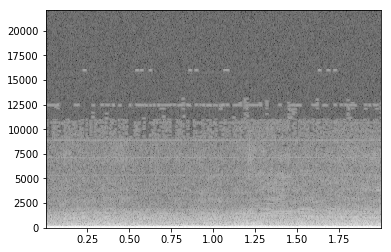

In [9]:
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.specgram.html

spectrum, freqs, t, im = plt.specgram(samples, NFFT=512, Fs=sample_rate, Fc=0, detrend=plt.mlab.detrend_none,
         window=plt.mlab.window_hanning, noverlap=384,
         cmap='gray', xextent=None, pad_to=None, sides='default',
         scale_by_freq=True, mode='default', scale='default')
# cmap='jet'
# cmap='gray'
# cmap=None

In order to save an image of 100x100 pixels we set the figure size to match that size and remove all axes and whitespace from the plot. Below is an example of a spectrogram. 

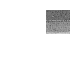

In [10]:
dpi = 300
im.figure.set_size_inches(100/dpi,100/dpi)
im.figure.frameon = False
im.figure.axes[0].set_axis_off()
im.figure.axes[0].set_position([0., 0., 1., 1.])
display(im.figure)
# im.figure.savefig("test.png", dpi=dpi)

We create a function `wav2spec` that can be used to convert an audio sample to a spectrogram. It will output a `.png` image with a filename like `{category}_{sample number}.png`, where the sample number is printed with leading zeros such that it has five digits.

In [11]:
def wav2spec(filename, readdir, savedir, category=None, nr=None, im_size=[100, 100], dpi=300):
	sample_rate, samples = wavfile.read(join(readdir, filename))
	spectrum, freqs, t, im = plt.specgram(samples, NFFT=512, Fs=sample_rate, Fc=0, detrend=plt.mlab.detrend_none,
         window=plt.mlab.window_hanning, noverlap=384,
         cmap='gray', xextent=None, pad_to=None, sides='default',
         scale_by_freq=True, mode='default', scale='default')
	im.figure.set_size_inches(im_size[0]/dpi,im_size[1]/dpi)
	im.figure.frameon = False
	im.figure.axes[0].set_axis_off()
	im.figure.axes[0].set_position([0., 0., 1., 1.])
	if category is None or nr is None:
		im.figure.savefig(join(savedir, filename.replace('.wav','.png')), dpi=dpi)
	else:
		im.figure.savefig(join(savedir, "{}_{:05d}.png".format(category, nr)), dpi=dpi)

The sample numbers will be unique across all samples and start from 0.

In [12]:
sample_nr = 0
# category = "bee"
# print("{}_{:05d}.png".format(category, samplenr))

This loop generates all the spectrograms for the training set of bee samples.

In [13]:
for bee_file in bee_files:
	wav2spec(bee_file,join(BUZZ_path, "bee"),join(BUZZ_path, "trainset"), "bee", sample_nr)
	sample_nr+=1

This loop generates all the spectrograms for the training set of cricket samples.

In [14]:
for cricket_file in cricket_files:
	wav2spec(cricket_file,join(BUZZ_path, "cricket"),join(BUZZ_path, "trainset"), "cricket", sample_nr)
	sample_nr+=1

This loop generates all the spectrograms for the training set of noise samples.

In [15]:
for noise_file in noise_files:
	wav2spec(noise_file,join(BUZZ_path, "noise"),join(BUZZ_path, "trainset"), "noise", sample_nr)
	sample_nr+=1

This loop generates all the spectrograms for the validation set of bee samples.

In [16]:
for bee_val_file in bee_val_files:
	wav2spec(bee_val_file,join(BUZZ_path,"out_of_sample_data_for_validation","bee_test"),join(BUZZ_path, "validationset"), "bee", sample_nr)
	sample_nr+=1

This loop generates all the spectrograms for the validation set of cricket samples.

In [17]:
for cricket_val_file in cricket_val_files:
	wav2spec(cricket_val_file,join(BUZZ_path,"out_of_sample_data_for_validation","cricket_test"),join(BUZZ_path, "validationset"), "cricket", sample_nr)
	sample_nr+=1

This loop generates all the spectrograms for the validation set of noise samples.

In [18]:
for noise_val_file in noise_val_files:
	wav2spec(noise_val_file,join(BUZZ_path,"out_of_sample_data_for_validation","noise_test"),join(BUZZ_path, "validationset"), "noise", sample_nr)
	sample_nr+=1

In [19]:
import tensorflow as tf